In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
from collections import deque
import time

from collections import deque
import time
import random
from tqdm import tqdm
import os
from PIL import Image
import cv2


In [2]:
DISCOUNT = 0.99
REPLAY_MEMORY_SIZE = 50000  # How many last steps to keep for model training
MIN_REPLAY_MEMORY_SIZE = 300  # Minimum number of steps in a memory to start training
MINIBATCH_SIZE = 64  # How many steps (samples) to use for training
UPDATE_TARGET_EVERY = 10  # Terminal states (end of episodes)
MODEL_NAME = 'window48_profit'
MIN_REWARD = -200  # For model save
MEMORY_FRACTION = 0.20

# Environment settings
EPISODES = 1000

# Exploration settings
epsilon = 1  # not a constant, going to be decayed
EPSILON_DECAY = 0.99975
MIN_EPSILON = 0.001

#  Stats settings
AGGREGATE_STATS_EVERY = 10  # episodes
SHOW_PREVIEW = True

# For stats
ep_rewards = [-200]

# For more repetitive results
random.seed(1)

# Memory fraction, used mostly when trai8ning multiple agents
#gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=MEMORY_FRACTION)
#backend.set_session(tf.Session(config=tf.ConfigProto(gpu_options=gpu_options)))

# Create models folder
if not os.path.isdir('models'):
    os.makedirs('models')




In [3]:
import gym
from gym import spaces
import numpy as np

class TimeSeriesEnv(gym.Env):
    def __init__(self, data, window_size=10):
        super(TimeSeriesEnv, self).__init__()
        self.data = data
        self.window_size = window_size
        self.current_step = window_size

        self.action_space = spaces.Discrete(3)  # 0 = hold, 1 = buy, 2 = sell
        self.observation_space = spaces.Box(
            low=0.0, high=1.0, shape=(window_size,), dtype=np.float32
        )

        self.inventory = []
        self.total_profit = 0.0
        self.states_buy = []
        self.states_sell = []
        
        self.min_val = np.min(data)
        self.max_val = np.max(data)

    def reset(self):
        self.current_step = self.window_size
        self.inventory = []
        self.total_profit = 0.0
        self.states_buy = []
        self.states_sell = []
        return self._get_observation()

    def _get_observation(self):
        past = self.data[self.current_step - self.window_size:self.current_step]
        #future = self.data[self.current_step:self.current_step + self.future_size]
        #obs = np.concatenate([past, future])

        self.min_val = np.min(past)
        self.max_val = np.min(past)
        return ((past - self.min_val) / (self.max_val - self.min_val + 1e-8)).astype(np.float32)

    def step(self, action):
        done = False
        reward = 0.0
        price = self.data[self.current_step]

        if action == 1:  # Buy
            self.inventory.append(price)
            self.states_buy.append(self.current_step)
            # Brak nagrody za samo kupno

        elif action == 2 and len(self.inventory) > 0:  # Sell
            bought_price = self.inventory.pop(0)
            profit = price - bought_price
            reward = profit #max(profit, 0)  # Możesz dać też samo `reward = profit` jeśli chcesz karać stratę
            self.total_profit += profit
            #reward = self.total_profit
            self.states_sell.append(self.current_step)

        # Hold (0) nic nie robi
        self.current_step += 1

        if self.current_step >= len(self.data):
            done = True
            if len(self.inventory) > 0:
                self.total_profit += np.sum(self.data[-1] - np.array(self.inventory, dtype=np.float32))


        return self._get_observation(), reward, done


In [4]:
import gym
from gymnasium import spaces
import numpy as np

class TimeSeries_VEC(gym.Env):
    def __init__(self, data, max_val, min_val, window_size=10):
        self.data = data.astype(np.float32)
        self.window_size = window_size
        self.current_step = window_size
        #self.device = device
        #self.lstm = lstm
        self.max_val = float(max_val)
        self.min_val = float(min_val)

        self.action_space = spaces.Discrete(3)  # 0 = hold, 1 = buy, 2 = sell
        self.observation_space = spaces.Box(
            low=0, high=1, shape=(window_size,), dtype=np.float32
        )

        self.inventory = []
        self.total_profit = 0.0
        self.states_buy = []
        self.states_sell = []

    def reset(self, *, seed=None, options=None):
        self.current_step = self.window_size
        self.inventory = []
        self.total_profit = 0.0
        self.states_buy = []
        self.states_sell = []

        if self.current_step >= len(self.data):
            raise ValueError("Dane są zbyt krótkie, by zobaczyć przyszłe punkty.")

        return self._get_observation(), {}

    def _get_observation(self):
        past = self.data[self.current_step - self.window_size:self.current_step]
        #past_lstm = self.lstm_data[self.current_step - self.window_size:self.current_step].astype(np.float32)

        #inputs = torch.from_numpy(past_lstm.astype(np.float32)).float().to(self.device)
        #outputs = self.lstm(inputs)
        #future = outputs.detach().cpu().numpy().flatten().astype(np.float32)

        #past = (past - self.train_mean) / self.train_std
        #obs = np.concatenate([past, future])
        #return ((past - self.min_val) / (self.max_val - self.min_val + 1e-8)).astype(np.float32)
        self.min_val = np.min(past)
        self.max_val = np.min(past)
        return ((past - self.min_val) / (self.max_val - self.min_val + 1e-8)).astype(np.float32)
        #return np.round(past.astype(np.float32), 3)

    def step(self, action):
        terminated = False
        truncated = False
        reward = 0.0
        price = self.data[self.current_step]

        if action == 1:  # Buy
            self.inventory.append(price)
            self.states_buy.append(self.current_step)

        elif action == 2 and len(self.inventory) > 0:  # Sell
            bought_price = self.inventory.pop(0)
            profit = price - bought_price
            reward = profit
            self.total_profit += profit
            self.states_sell.append(self.current_step)

        self.current_step += 1

        if self.current_step >= len(self.data):
            terminated = True
            if len(self.inventory) > 0:
                self.total_profit += np.sum(self.data[-1] - np.array(self.inventory, dtype=np.float32))

        return self._get_observation(), self.total_profit, terminated, truncated, {}


In [5]:
# import pandas as pd
# df = pd.read_csv('data/SP500.csv')
# data = df['Close'].values
# # data

In [6]:
#len(data)  * 0.8

In [26]:

add_trend = np.logspace(np.log(1.08), np.log(2), 500, base=np.exp(2))
data = np.sin(np.linspace(0, 100, 500)).astype(np.float32)# + add_trend
data_split = int(len(data)  * 0.8)
train_data = data[:data_split]
valid_data = data[data_split:]

env = TimeSeriesEnv(data, window_size=48)
valid_env = TimeSeriesEnv(valid_data,window_size=48)

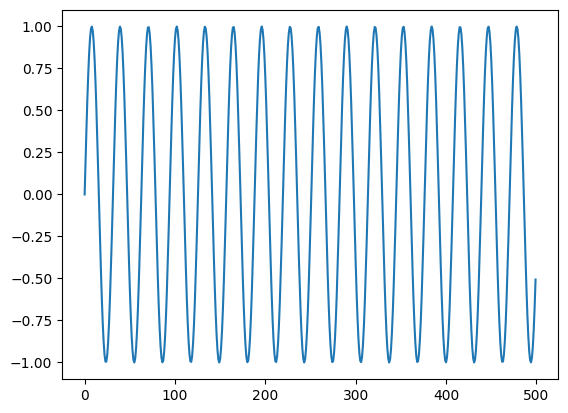

In [27]:
import matplotlib.pyplot as plt

plt.plot(data)

In [28]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Prosta sieć neuronowa w PyTorchu
class DQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 32)
        self.fc2 = nn.Linear(32, 16)
        self.fc3 = nn.Linear(16, 8)
        self.output = nn.Linear(8, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        return self.output(x)

# class DQN(nn.Module):
# 	def __init__(self, input_dim, output_dim):
# 		super(DQN, self).__init__()
# 		self.out_steps = output_dim

# 		self.lstm = nn.LSTM(input_size=input_dim, hidden_size=32, batch_first=True)
# 		self.dropout = nn.Dropout(p=0.2)

# 		self.fc = nn.Linear(32, 16)
# 		self.fc2 = nn.Linear(16, output_dim)

# 	def forward(self, x):
# 		#_, (h_n, _) = self.lstm(x)  # h_n: [1, batch, lstm_units]
# 		h_n, _ = self.lstm(x)  # h_n: [1, batch, lstm_units]

# 		h_n = h_n.squeeze(0)        # [batch, lstm_units]
# 		#h_n = self.dropout(h_n)        # [batch, lstm_units]

# 		x = torch.relu(self.fc(h_n))            # [batch, out_steps * num_features]
# 		x = self.dropout(x)            # [batch, out_steps * num_features]
  
# 		x = torch.relu(self.fc2(x))		# [out_steps * num_features, close_price]
# 		#x = self.dropout(x)            # [batch, out_steps * num_features]

# 		x = x.view(-1, self.out_steps, 1)
# 		return x




class DQNAgent:
    def __init__(self):
        self.model = DQN(env.observation_space.shape[0], env.action_space.n).to(device)
        self.target_model = DQN(env.observation_space.shape[0], env.action_space.n).to(device)
        self.target_model.load_state_dict(self.model.state_dict())
        self.target_model.eval()

        self.optimizer = optim.Adam(self.model.parameters(), lr=0.001)
        self.loss_fn = nn.MSELoss()

        self.replay_memory = deque(maxlen=REPLAY_MEMORY_SIZE)
        self.target_update_counter = 0

    def update_replay_memory(self, transition):
        self.replay_memory.append(transition)

    def train(self, terminal_state):
        if len(self.replay_memory) < MIN_REPLAY_MEMORY_SIZE:
            return

        # minibatch = random.sample(self.replay_memory, MINIBATCH_SIZE)

        # #states = np.array([t[0] for t in minibatch]) / 255.0
        # actions = np.array([t[1] for t in minibatch])
        # rewards = np.array([t[2] for t in minibatch])
        # #next_states = np.array([t[3] for t in minibatch]) / 255.0
        # dones = np.array([t[4] for t in minibatch])
        # # states = (np.array([t[0] for t in minibatch]) - min_val) / (max_val - min_val + 1e-8)
        # # next_states = (np.array([t[3] for t in minibatch]) - min_val) / (max_val - min_val + 1e-8)
        # states = np.array([t[0] for t in minibatch])
        # next_states = np.array([t[3] for t in minibatch])

        # states_v = torch.tensor(states, dtype=torch.float32).to(device)
        # next_states_v = torch.tensor(next_states, dtype=torch.float32).to(device)
        # actions_v = torch.tensor(actions, dtype=torch.int64).to(device)
        # rewards_v = torch.tensor(rewards, dtype=torch.float32).to(device)
        # dones_v = torch.tensor(dones, dtype=torch.bool).to(device)
        minibatch = random.sample(self.replay_memory, MINIBATCH_SIZE)

        # Rozpakowanie danych
        states, actions, rewards, next_states, dones = zip(*minibatch)

        states_v = torch.from_numpy(np.array(states)).float().to(device)
        next_states_v = torch.from_numpy(np.array(next_states)).float().to(device)
        actions_v = torch.tensor(actions, dtype=torch.int64, device=device)
        rewards_v = torch.tensor(rewards, dtype=torch.float32, device=device)
        dones_v = torch.tensor(dones, dtype=torch.bool, device=device)        
        
        with torch.no_grad():
            target_qs = self.target_model(next_states_v).flatten(start_dim=1)
            max_future_qs = torch.max(target_qs, dim=1)[0]
            new_qs = rewards_v + (~dones_v * DISCOUNT * max_future_qs)

        #print(states_v.shape)
        current_qs = self.model(states_v).flatten(start_dim=1)
        #print(current_qs.flatten(start_dim=1).shape)
        #print(actions_v.shape)
        predicted_qs = current_qs.gather(1, actions_v.unsqueeze(1)).squeeze()

        loss = self.loss_fn(predicted_qs, new_qs)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        if terminal_state:
            self.target_update_counter += 1

        if self.target_update_counter > UPDATE_TARGET_EVERY:
            self.target_model.load_state_dict(self.model.state_dict())
            self.target_update_counter = 0

    def get_qs(self, state):
        #state = np.array(state) / 255.0
        state_v = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)
        with torch.no_grad():
            qs = self.model(state_v)
        return qs.cpu().numpy()[0]


In [29]:
from copy import deepcopy
agent = DQNAgent()
reward_all = []

In [ ]:
import multiprocessing

EPSILON_DECAY = 0.998
#EPSILON_DECAY = 0.99

def train_episode(episode, epsilon):
    # Update tensorboard step every episode
    #agent.tensorboard.step = episode

    # Restarting episode - reset episode reward and step number
    episode_reward = 0
    step = 1

    # Reset environment and get initial state
    current_state = env.reset()

    # Reset flag and start iterating until episode ends
    done = False
    while not done:

        # This part stays mostly the same, the change is to query a model for Q values
        if np.random.random() > epsilon:
            # Get action from Q table
            action = np.argmax(agent.get_qs(current_state))
        else:
            # Get random action
            action = np.random.randint(0, env.action_space.n)

        new_state, reward, done = env.step(action)

        # Transform new continous state to new discrete state and count reward
        episode_reward += reward


        # Every step we update replay memory and train main network
        agent.update_replay_memory((current_state, action, reward, new_state, done))
        agent.train(done)

        current_state = new_state
        step += 1
 
    # Append episode reward to a list and log stats (every given number of episodes)
    ep_rewards.append(episode_reward)
    if SHOW_PREVIEW and not episode % AGGREGATE_STATS_EVERY:
            print(f"Episode: {episode} Total Reward: {env.total_profit} Epsilon: {epsilon:.2f}")

    
    if not episode % AGGREGATE_STATS_EVERY or episode == 1:
        average_reward = sum(ep_rewards[-AGGREGATE_STATS_EVERY:])/len(ep_rewards[-AGGREGATE_STATS_EVERY:])
        min_reward = min(ep_rewards[-AGGREGATE_STATS_EVERY:])
        max_reward = max(ep_rewards[-AGGREGATE_STATS_EVERY:])
        #agent.tensorboard.update_stats(reward_avg=average_reward, reward_min=min_reward, reward_max=max_reward, epsilon=epsilon)

        # Save model, but only when min reward is greater or equal a set value
        #if min_reward >= MIN_REWARD:
        #    agent.model.save(f'models/{MODEL_NAME}__{max_reward:_>7.2f}max_{average_reward:_>7.2f}avg_{min_reward:_>7.2f}min__{int(time.time())}.h5')

    # Decay epsilon
    if epsilon > MIN_EPSILON:
        epsilon *= 0.97#EPSILON_DECAY
        epsilon = max(MIN_EPSILON, epsilon)

    return episode_reward

EPISODES = 50
# Iterate over episodes
max_agent = DQNAgent()
max_reward = 0
for episode in tqdm(range(1, EPISODES + 1), ascii=True, unit='episodes'):
    reward = train_episode(episode,epsilon)
    
    
    if epsilon > MIN_EPSILON:
        epsilon *= EPSILON_DECAY
        epsilon = max(MIN_EPSILON, epsilon)

    if reward > max_reward and episode > 10:
        max_reward = reward
        max_agent = deepcopy(agent)
    
    reward_all.append(reward)
 
    

#przed opt - 18 min

 20%|##        | 10/50 [00:13<00:52,  1.30s/episodes]

Episode: 10 Total Reward: 4.8782729879021645 Epsilon: 0.89


 40%|####      | 20/50 [00:26<00:38,  1.30s/episodes]

Episode: 20 Total Reward: -1.7456213384866714 Epsilon: 0.87


 50%|#####     | 25/50 [00:33<00:31,  1.28s/episodes]

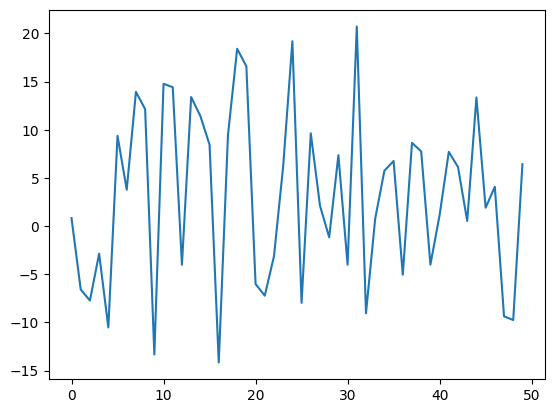

In [ ]:
import matplotlib.pyplot as plt
plt.plot(reward_all)

In [ ]:
# from multiprocessing import Pool
# from tqdm import tqdm

# def train_wrapper(episode, epsilon):
#     return train_episode(episode, epsilon)

# if __name__ == "__main__":
#     with Pool() as pool:
#         results = list(tqdm(pool.starmap(train_wrapper, [(episode, epsilon) for episode in range(1, EPISODES + 1)]), total=EPISODES, ascii=True, unit='episodes'))

In [ ]:
#from multiprocessing import Pool




#with Pool() as p:
#    print(p.map(train_episode, [episode for episode in range(1, EPISODES + 1)]))

In [ ]:
# def save_dqn_agent(agent, filename="dqn_model.pth"):
#     torch.save({
#         'model_state_dict': agent.model.state_dict(),
#         'target_model_state_dict': agent.target_model.state_dict(),
#         'optimizer_state_dict': agent.optimizer.state_dict(),
#     }, filename)

# save_dqn_agent(agent, "SPY_AGENT.pth")

In [ ]:
ep_rewards

[-200,
 0.8245189487934113,
 -6.5898904129862785,
 -7.728566884994507,
 -2.8688147515058517,
 -10.517857789993286,
 9.369845896959305,
 3.7743784487247467,
 13.932056427001953,
 12.137517929077148,
 -13.332654885947704,
 14.76677131652832,
 14.412187553942204,
 -4.016508489847183,
 13.387801244854927,
 11.421985059976578,
 8.445327371358871,
 -14.15989724546671,
 9.429908275604248,
 18.400355681777,
 16.58283530920744,
 -6.01375474780798,
 -7.226524770259857,
 -3.14044426381588,
 6.198678523302078,
 19.186436899006367,
 -7.969067096710205,
 9.631234392523766,
 2.12259291857481,
 -1.1676038205623627,
 7.356088111177087,
 -4.009222775697708,
 20.714986957609653,
 -9.056435782462358,
 0.7724994719028473,
 5.739571258425713,
 6.753907948732376,
 -5.0540792644023895,
 8.635962039232254,
 7.748809799551964,
 -4.004550956189632,
 1.1335704699158669,
 7.7012404799461365,
 6.123038023710251,
 0.5259549468755722,
 13.349384039640427,
 1.9030087944120169,
 4.071493849158287,
 -9.36923810839653,
 

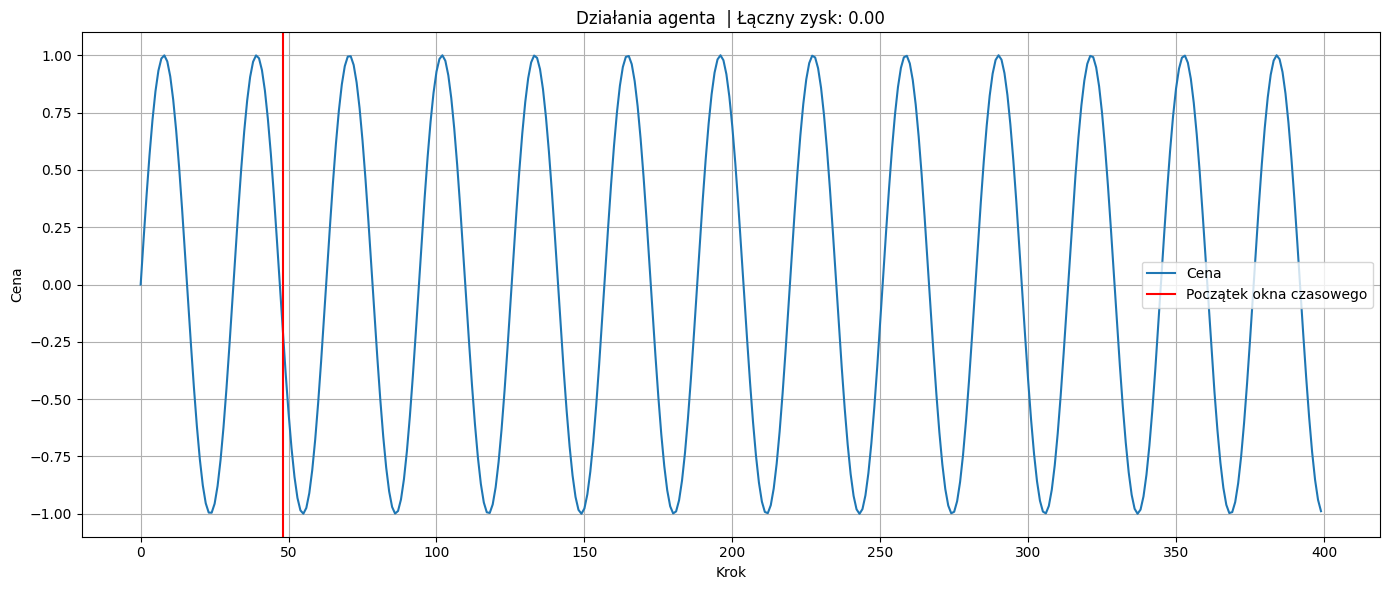

In [ ]:
import torch
import matplotlib.pyplot as plt


def evaluate_steps(env, model, device="cuda:0"):
    state = env.reset()
    total_reward = 0
    done = False
    steps = 0
    action = 0
    while not done:
        # konwersja stanu na tensora
        state_tensor = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)

        with torch.no_grad():
            q_values = model(state_tensor)
            action = torch.argmax(q_values).item()

        state, reward, done = env.step(action)
        total_reward += reward
        steps += 1
        #print(f"Krok: {steps}, Akcja: {action}, Nagroda: {reward:.2f}, Łączny zysk: {env.total_profit:.2f}")

    #print(state_tensor)
    return total_reward


def render_env(env, title_suffix=""):
    prices = env.data
    buy_points = env.states_buy
    sell_points = env.states_sell
    profit = env.total_profit

    plt.figure(figsize=(14, 6))
    plt.plot(prices, label='Cena', linewidth=1.5)

    if buy_points:
        plt.scatter(buy_points, [prices[i] for i in buy_points],
                    color='green', marker='^', label='Kup', s=100)
    if sell_points:
        plt.scatter(sell_points, [prices[i] for i in sell_points],
                    color='red', marker='v', label='Sprzedaj', s=100)

    plt.title(f'Działania agenta {title_suffix} | Łączny zysk: {profit:.2f}')
    plt.axvline(x = 48, color = 'red', label = 'Początek okna czasowego')
    plt.xlabel('Krok')
    plt.ylabel('Cena')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


env.reset()
evaluate_steps(env, max_agent.target_model)
render_env(env, title_suffix="")

In [ ]:
# from source.IB_connector import retrive_market_data
# ticker = 'AAPL'
# training_set_aapl = retrive_market_data([ticker], duration = "3 m", time_interval = "15 mins")
# training_set = training_set_aapl[ticker]
# training_set['Volume'] = training_set['Volume'].astype(float)
# training_set['Date'] = pd.to_datetime(training_set['Date'].str.replace(' US/Eastern',''),format="%Y%m%d %H:%M:%S")
# col_select = ['Open','High','Low','Close','Volume']
# training_set = training_set[col_select]
# training_set.dtypes
# CLOSE_INDEX = col_select.index('Close')

In [ ]:
# env = TimeSeriesEnv(data=training_set['Close'].values, window_size=48)

# env.reset()
# evaluate_steps(env, agent.target_model)
# render_env(env, title_suffix="")